In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pywt
from scipy import stats
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA

In [11]:
def denoise_and_backcast(file_path, num_simulations=100, wavelet='db4', level=4):
    """
    Denoises a financial returns time series using wavelet transform,
    backcasts the trend using StatsForecast, and adds resampled noise 
    to generate simulations.

    Args:
        file_path (str): The path to the CSV file containing the financial data.
                         The file must have 'ds' and 'y' columns.
        num_simulations (int): The number of backcasting simulations to run.
        wavelet (str): The type of wavelet to use for the transform.
        level (int): The decomposition level for the wavelet transform.

    Returns:
        tuple: A tuple containing simulated_backcasts, full_simulated_returns, 
               and simulated_equity_curves, or None on error.
    """
    # --- 1. Load and Prepare Data ---
    try:
        df = pd.read_csv(file_path, parse_dates=['ds'], index_col='ds')
        # Calculate daily returns from the 'y' column, dropping NaNs from pct_change
        returns = df['y'].dropna().pct_change().dropna()
        returns_reverted = df['y'].dropna()[::-1].pct_change().dropna()

    except FileNotFoundError:
        print(f"Error: The file at {file_path} was not found.")
        return None, None, None
    except KeyError:
        print("Error: The CSV must contain 'ds' and 'y' columns.")
        return None, None, None

    # --- 2. Denoise with Wavelet Transform ---
    # Decompose the signal
    coeffs = pywt.wavedec(returns, wavelet, level=level)

    # Threshold the detail coefficients (a simple denoising method)
    coeffs_thresholded = [coeffs[0]] + [np.zeros_like(c) for c in coeffs[1:]]

    # Reconstruct the denoised signal (trend)
    denoised_trend = pywt.waverec(coeffs_thresholded, wavelet)
    # Ensure the trend has the same length as the returns series
    denoised_trend = denoised_trend[:len(returns)]

    # The noise is the difference between the original signal and the trend
    noise = returns - denoised_trend

    print("Step 1 & 2: Denoising complete.")
    print(f"Original series length: {len(returns)}")
    print(f"Denoised trend length: {len(denoised_trend)}")
    print(f"Noise length: {len(noise)}")

    # --- 3. Backcast the Denoised Trend using StatsForecast ---
    # To backcast, we reverse the series, forecast with AutoARIMA, and then reverse the forecast.
    
    # Prepare the DataFrame for StatsForecast
    trend_df = pd.DataFrame({
        'ds': returns.index,
        'y': denoised_trend
    })
    trend_df['unique_id'] = 'trend'
    
    # Reverse the DataFrame for backcasting
    reversed_trend_df = trend_df.iloc[::-1].reset_index(drop=True)
    reversed_trend_df['ds'] = pd.to_datetime(reversed_trend_df.index, unit='D') # Create a dummy date index

    # Set the number of backcast steps based on NaN values
    backcast_steps = df.isna().any(axis=1).sum()

    # Initialize and fit the StatsForecast model
    sf = StatsForecast(
        models=[AutoARIMA()],
        freq='B', # Business day frequency
        n_jobs=-1
    )
    sf.fit(reversed_trend_df)

    # "Forecast" the reversed series to get backcasted values
    predicted_reversed_df = sf.predict(h=backcast_steps)
    
    # Reverse the predictions to get the final backcasted trend
    backcasted_trend = predicted_reversed_df['AutoARIMA'].values[::-1]
    
    print(f"\nStep 3: Backcasting of the denoised trend complete.")
    print(f"Backcasted {backcast_steps} steps into the past.")


    # --- 4. Fit a Distribution to the Noise ---
    # Fit a t-distribution to the noise
    params = stats.t.fit(noise)
    dof, loc, scale = params
    fitted_dist = stats.t(dof, loc, scale)

    # Perform a Kolmogorov-Smirnov test for goodness-of-fit
    ks_statistic, p_value = stats.kstest(noise, fitted_dist.cdf)

    print("\nStep 4: Fitting distribution to noise complete.")
    print(f"Fitted t-distribution parameters: df={dof:.2f}, loc={loc:.4f}, scale={scale:.4f}")
    print(f"Kolmogorov-Smirnov Test: Statistic={ks_statistic:.4f}, p-value={p_value:.4f}")
    if p_value > 0.05:
        print("The p-value is > 0.05, so we don't reject the null hypothesis that the noise follows the fitted t-distribution.")
    else:
        print("The p-value is <= 0.05, suggesting the noise may not perfectly follow the fitted t-distribution.")


    # --- 5. Resample Noise and Create Simulations ---
    simulated_backcasts = []
    for _ in range(num_simulations):
        # Resample from the fitted noise distribution
        resampled_noise = fitted_dist.rvs(size=backcast_steps)
        # Add the resampled noise to the backcasted trend
        simulation = backcasted_trend + resampled_noise
        simulated_backcasts.append(simulation)

    simulated_backcasts = np.array(simulated_backcasts)
    print(f"\nStep 5: Generated {num_simulations} simulations.")


    # --- 6. Plot the Results ---
    plt.style.use('seaborn-v0_8-darkgrid')
    
    # --- CHART 1: Denoising Plot ---
    fig1, ax1 = plt.subplots(figsize=(15, 6))
    ax1.plot(returns.index, returns, label='Original Returns', alpha=0.6)
    ax1.plot(returns.index, denoised_trend, label='Denoised Trend (Wavelet)', color='red', linewidth=2)
    ax1.set_title('Original Returns vs. Denoised Trend', fontsize=16)
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Returns')
    ax1.legend()
    ax1.grid(True)
    fig1.autofmt_xdate()
    plt.show()

    # --- CHART 2: Simulated Backcasts Plot ---
    fig2, ax2 = plt.subplots(figsize=(15, 8))
    
    # Get the index for the backcasted period
    backcast_index = df.iloc[len(returns)+1:].index

    simulated_equity_curves = []
    full_simulated_returns = None # Initialize to handle case where loop doesn't run

    # Plot simulated backcasts
    for i in range(num_simulations):
        ax2.plot(backcast_index, simulated_backcasts[i], color='grey', alpha=0.1)

        # Concatenate the simulated backcasted returns with the actual historical returns
        full_simulated_returns = np.concatenate([simulated_backcasts[i], returns_reverted.values])
        # Calculate the equity curve using cumulative product
        equity_curve = (1 + full_simulated_returns).cumprod()
        simulated_equity_curves.append(equity_curve)

    # Plot backcasted trend on top
    ax2.plot(backcast_index, backcasted_trend, label='Backcasted Trend (AutoARIMA)', color='green', linewidth=2)

    ax2.set_title(f'{num_simulations} Simulated Backcasts', fontsize=16)
    ax2.set_xlabel('ds')
    ax2.set_ylabel('Returns')
    ax2.legend()
    ax2.grid(True)
    fig2.autofmt_xdate()
    
    plt.tight_layout()
    plt.show()

    return simulated_backcasts, full_simulated_returns, simulated_equity_curves, reversed_trend_df

def plot_equity_curves(equity_curves, num_to_plot, data_range=slice(None), title='Simulated Equity Curves'):
    """
    Visualizes a specified number of simulated equity curves over a defined data range.

    Args:
        equity_curves (list of np.ndarray): The list of all simulated equity curves.
        num_to_plot (int): The number of simulations to display on the chart.
        data_range (slice, optional): A slice object to specify the portion of the data to plot. 
                                      Defaults to slice(None) (the full range).
        title (str, optional): The title for the plot. Defaults to 'Simulated Equity Curves'.
    """
    if not equity_curves:
        print("No equity curves to plot.")
        return

    num_to_plot = min(num_to_plot, len(equity_curves))
    
    plt.figure(figsize=(15, 8))
    
    for i in range(num_to_plot):
        # Apply the specified slice to the equity curve before plotting
        plt.plot(equity_curves[i][data_range])
        
    plt.title(title, fontsize=16)
    plt.xlabel("Time Steps")
    plt.ylabel("Cumulative Growth")
    plt.grid(True)
    plt.show()

Step 1 & 2: Denoising complete.
Original series length: 770
Denoised trend length: 770
Noise length: 770

Step 3: Backcasting of the denoised trend complete.
Backcasted 3947 steps into the past.

Step 4: Fitting distribution to noise complete.
Fitted t-distribution parameters: df=4.70, loc=-0.0000, scale=0.0098
Kolmogorov-Smirnov Test: Statistic=0.0175, p-value=0.9688
The p-value is > 0.05, so we don't reject the null hypothesis that the noise follows the fitted t-distribution.

Step 5: Generated 10 simulations.


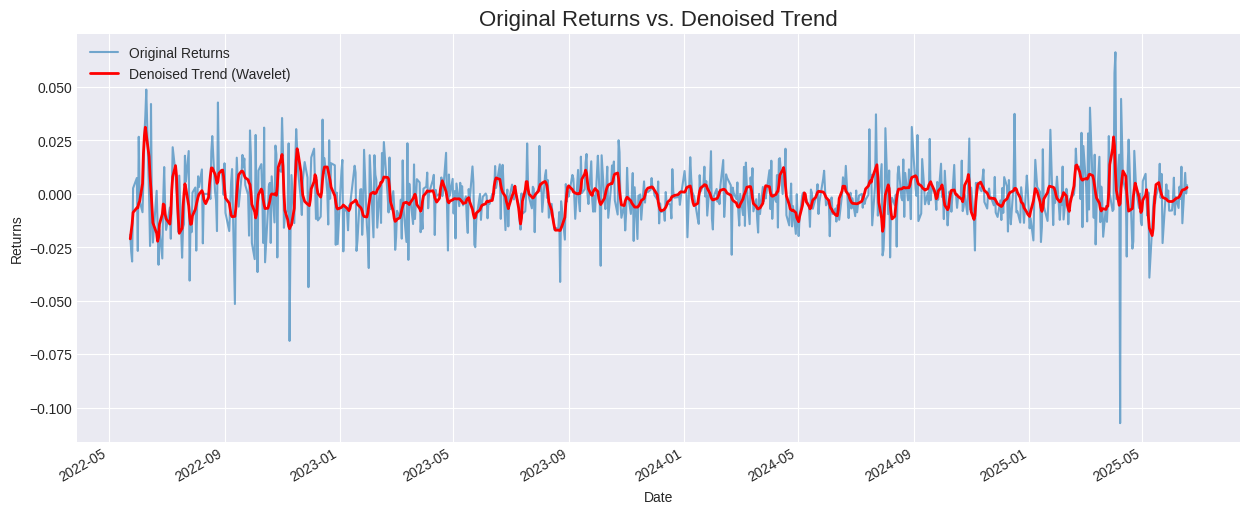

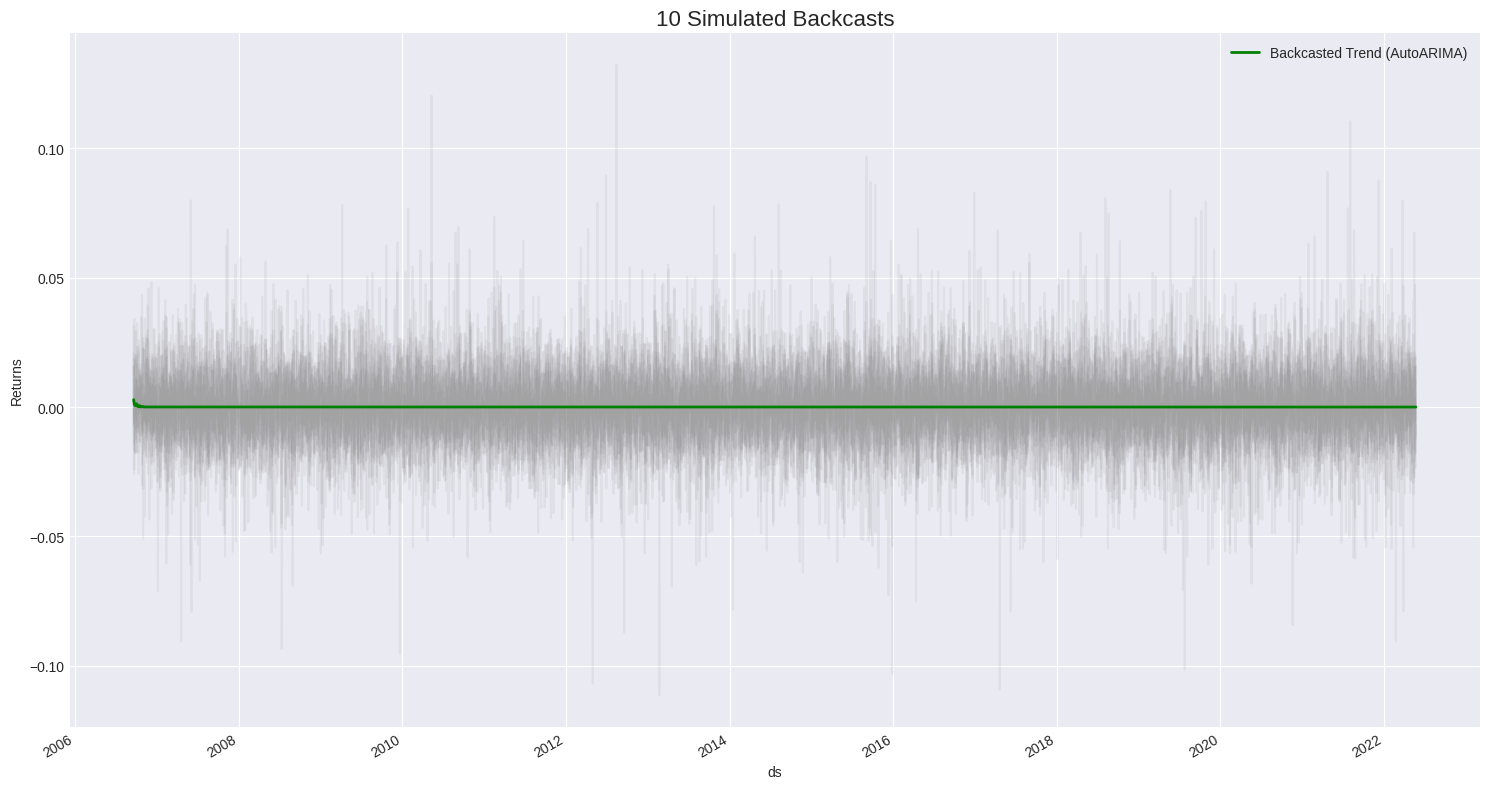


Returned simulations shape: (10, 3947)


In [29]:
# Use the specified input file
file_name = './data/merged_df_final_reversed_4.csv'
simulated_backcasts, full_simulated_returns, simulated_equity_curves, reversed_trend_df = denoise_and_backcast(file_name, num_simulations=10, level=2)
if simulated_backcasts is not None:
    print("\nReturned simulations shape:", simulated_backcasts.shape)

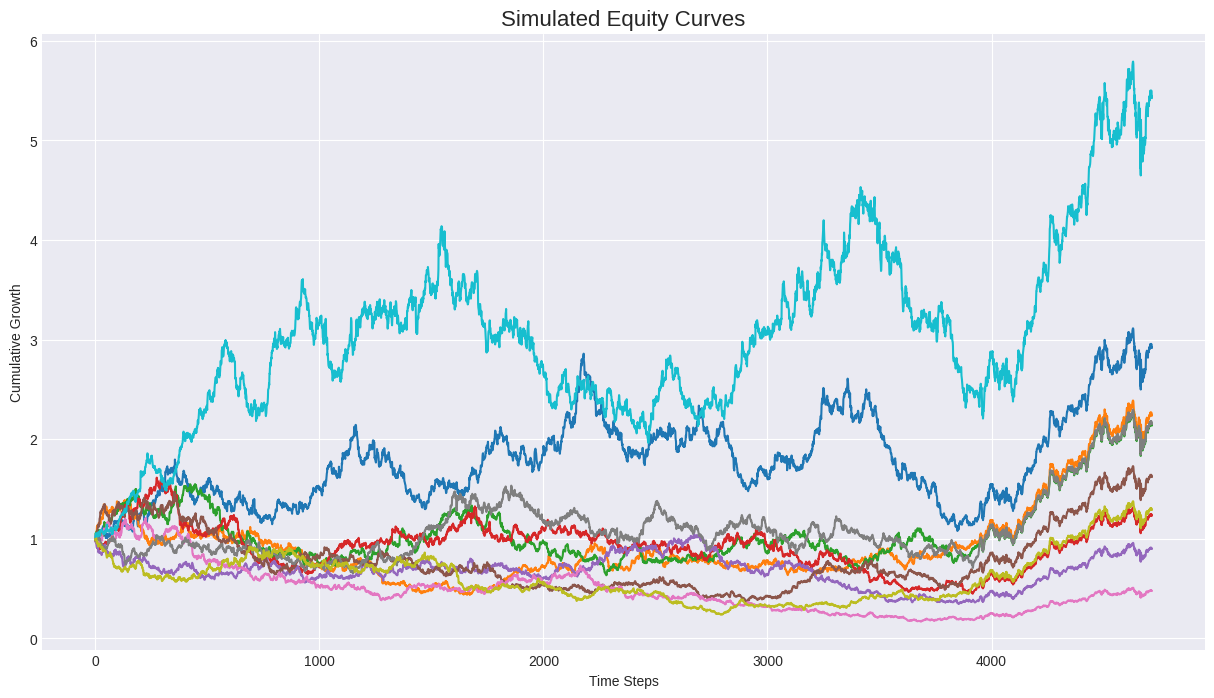

In [30]:
plot_equity_curves(
    simulated_equity_curves,
    num_to_plot=10,
    # data_range=slice(0, 1000),
    # data_range=slice(1000, 2000),
    # data_range=slice(2000, 3000),
    # data_range=slice(3000, 4000),
    # data_range=slice(4000, 5000),
    data_range=slice(0, 5000),

    title='Simulated Equity Curves'
)